In [1]:
#from python=3.10

#!pip install scikit-learn ipykernel pandas plotly matplotlib
#!pip install xgboost

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
%ls -l

total 1220
drwxrwxr-x 2 david david   4096 Nov  2 00:59  data_split_idx/
-rw-rw-r-- 1 david david 363547 Nov  3 01:40  EDA.ipynb
-rw-rw-r-- 1 david david 875538 Nov  1 10:18 'Solar_Data.xlsx - Sheet1.csv'
-rw-rw-r-- 1 david david    488 Nov  1 23:33  tf_nn.txt


In [4]:
df = pd.read_csv('Solar_Data.xlsx - Sheet1.csv')

# Data conversions
df['DateTime'] = pd.to_datetime(df['Time'])
df = df.drop(labels='Time', axis=1)
df['Label'] = df['Label'].astype("category")
df = df.drop(labels='Panel No.', axis=1)

#df['Time'] = df['DateTime'].dt.strftime("%H:%M:%S")
df['Hour'] = df['DateTime'].dt.strftime("%H")
df['Hour'] = df['Hour'].astype("float64")
df['Minute'] = df['DateTime'].dt.strftime("%M")
df['Minute'] = df['Minute'].astype("float64")
df['Hour'] = df['Hour'] + df['Minute'].div(60)
df = df.drop(labels='Minute', axis=1)

In [5]:
df.head()

,Temperature,Voltage,Current,Irradiance,Power,Gamma,Label,DateTime,Hour
0,38.50,32.37,3.23,487,104.5551,0.214692,0,2023-10-23 09:22:37,9.366667
1,38.25,32.58,3.23,503,105.2334,0.209212,0,2023-10-23 09:22:42,9.366667
2,38.75,33.09,3.21,506,106.2189,0.209919,0,2023-10-23 09:22:47,9.366667
3,39.00,32.37,3.26,495,105.5262,0.213184,0,2023-10-23 09:22:52,9.366667
4,38.50,32.88,3.26,498,107.1888,0.215239,0,2023-10-23 09:22:57,9.366667


In [6]:
df.tail()

,Temperature,Voltage,Current,Irradiance,Power,Gamma,Label,DateTime,Hour
13280,41.75,36.98,0.79,425,29.2142,0.068739,3,2023-10-27 15:29:41,15.483333
13281,42.25,36.26,0.83,409,30.0958,0.073584,3,2023-10-27 15:29:46,15.483333
13282,41.75,36.78,0.81,420,29.7918,0.070933,3,2023-10-27 15:29:51,15.483333
13283,42.00,37.29,0.79,428,29.4591,0.068830,3,2023-10-27 15:29:56,15.483333
13284,41.75,37.60,0.74,445,27.8240,0.062526,3,2023-10-27 15:30:01,15.500000


In [7]:
print(df.dtypes)

Temperature           float64
Voltage               float64
Current               float64
Irradiance              int64
Power                 float64
Gamma                 float64
Label                category
DateTime       datetime64[ns]
Hour                  float64
dtype: object


# Data Analysis

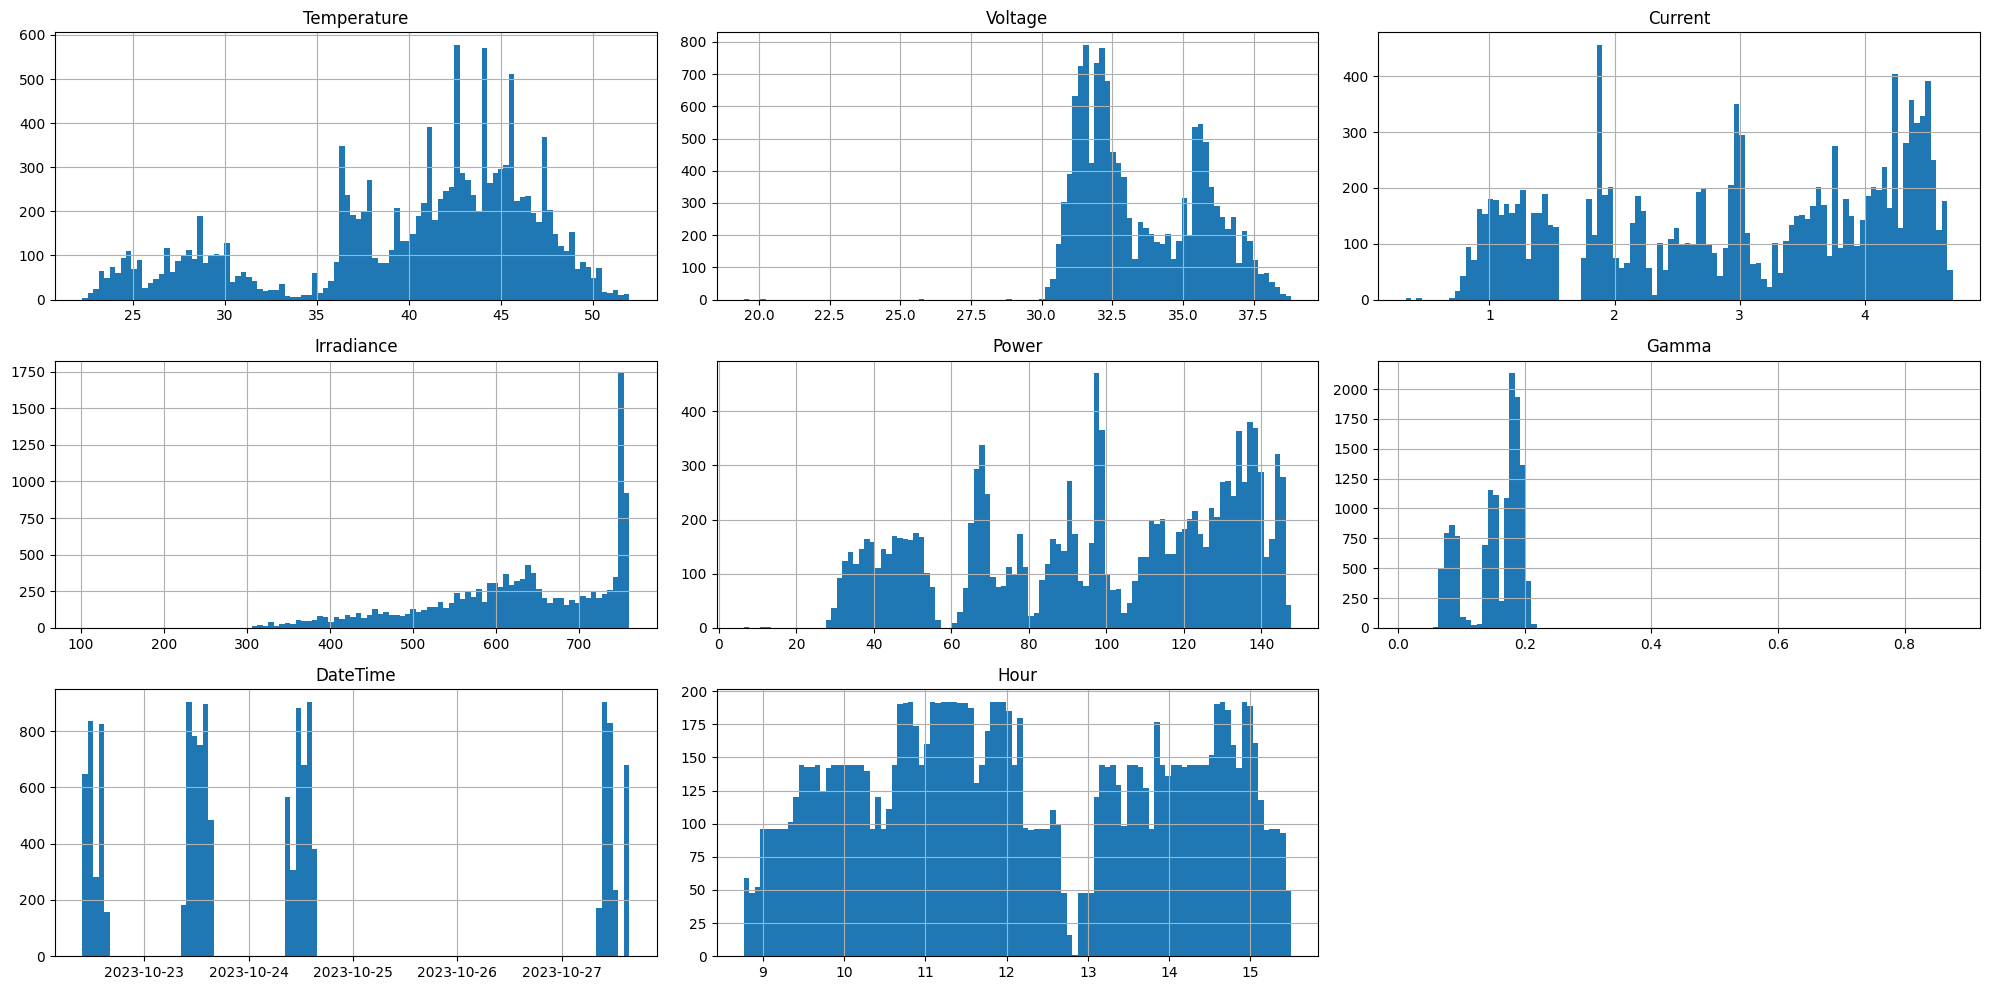

In [8]:
df.hist(bins=100, figsize=(20, 10), log=False)
plt.tight_layout()
plt.show()

Log Scaled Histogram


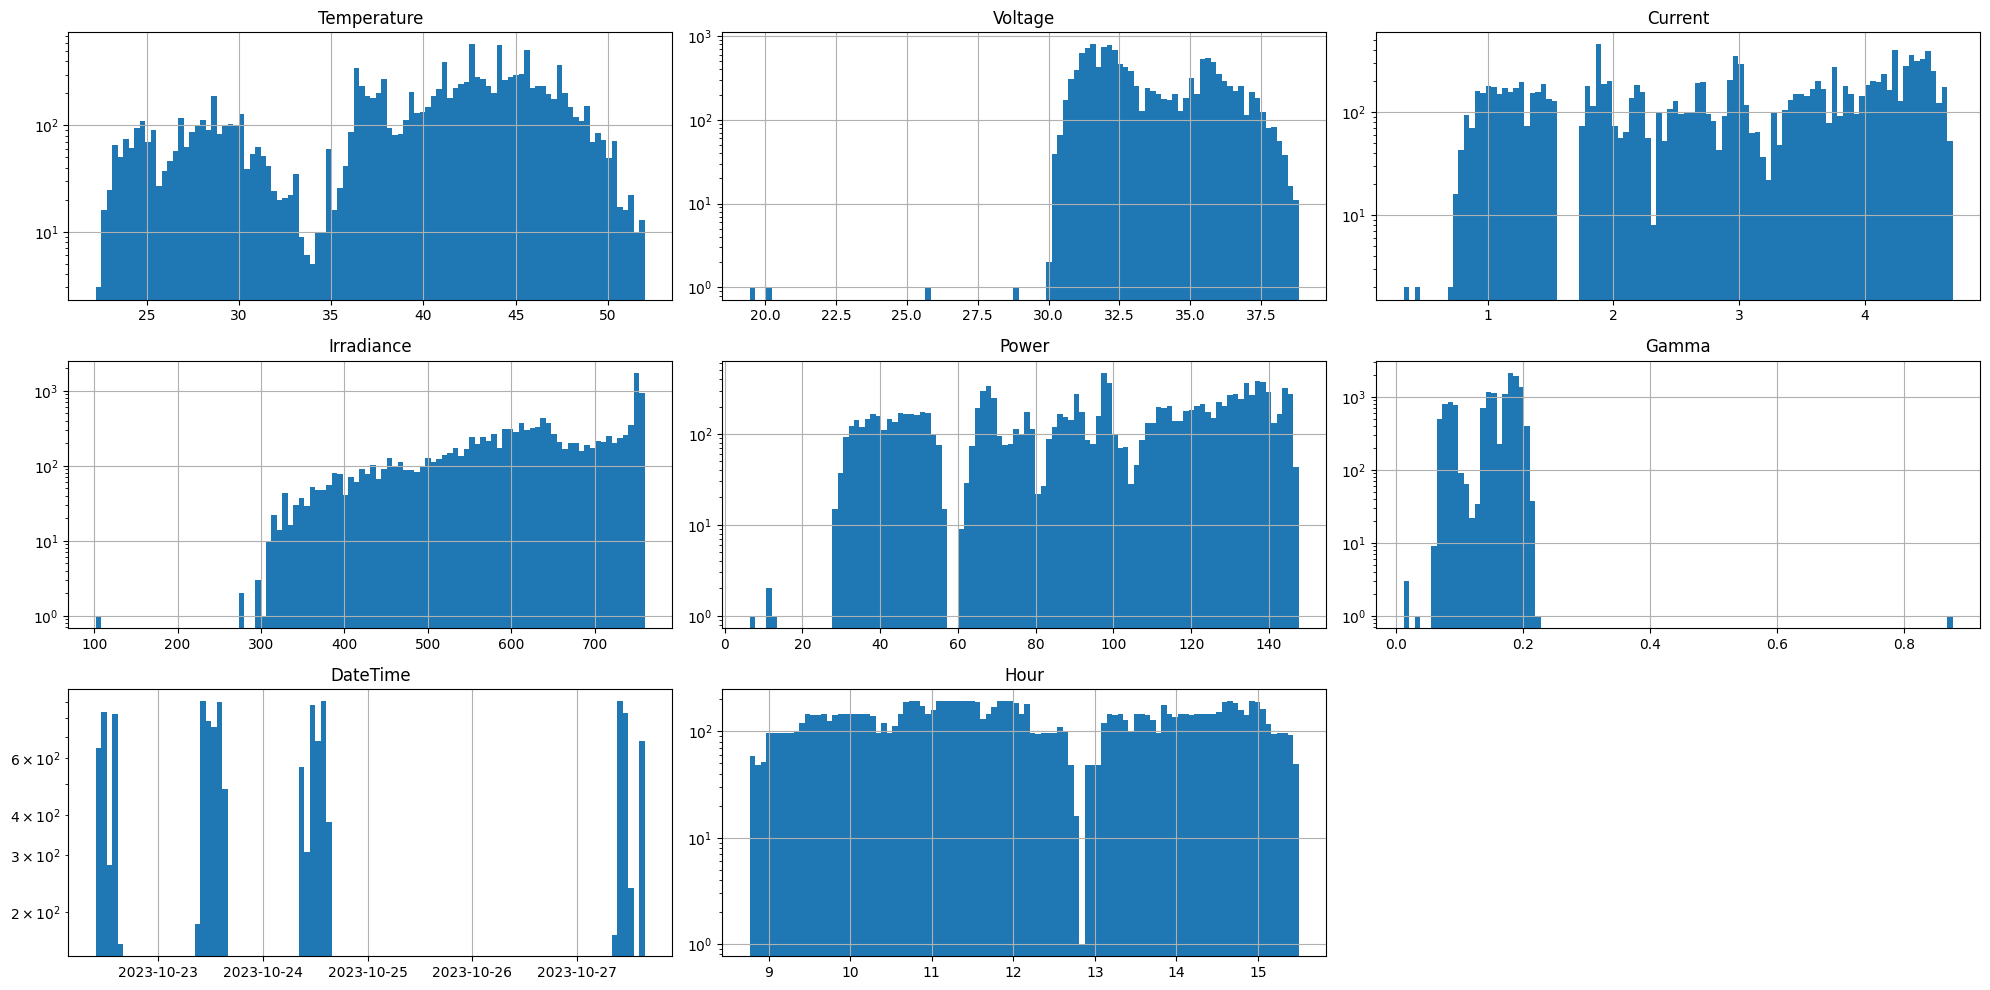

What's up with these weird anomalies...


In [9]:
print("Log Scaled Histogram")
df.hist(bins=100, figsize=(20, 10), log=True)
plt.tight_layout()
plt.show()
print("What's up with these weird anomalies...")

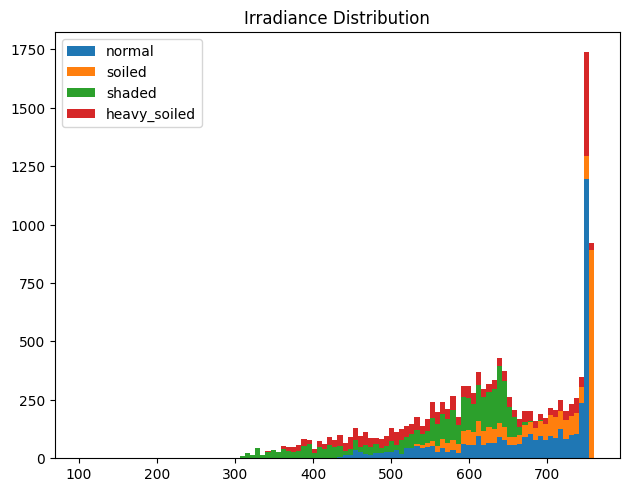

Mostly evenly distributed irradiance
Maybe the day of shaded capture was less irradiance


In [10]:
# We want to seperate by category

def dataframe_splitter(df, column):
    label_0 = df[df['Label']==0]
    label_1 = df[df['Label']==1]
    label_2 = df[df['Label']==2]
    label_3 = df[df['Label']==3]
    df_by_label = [label_0[column], label_1[column], label_2[column], label_3[column]]
    return df_by_label

label_names = ["normal","soiled","shaded","heavy_soiled"]

df_by_label = dataframe_splitter(df, "Irradiance")

plt.hist(df_by_label, bins=100, stacked=True)
plt.legend(label_names)
plt.tight_layout()
plt.title("Irradiance Distribution")
plt.show()
print("Mostly evenly distributed irradiance")
print("Maybe the day of shaded capture was less irradiance")

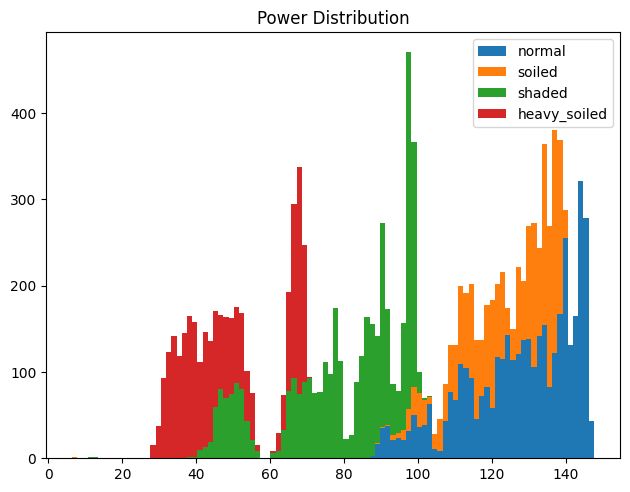

Power outcome is seperated by class as you would expect


In [11]:
df_by_label = dataframe_splitter(df, "Power")

plt.hist(df_by_label, bins=100, stacked=True)
plt.legend(label_names)
plt.tight_layout()
plt.title("Power Distribution")
plt.show()
print("Power outcome is seperated by class as you would expect")

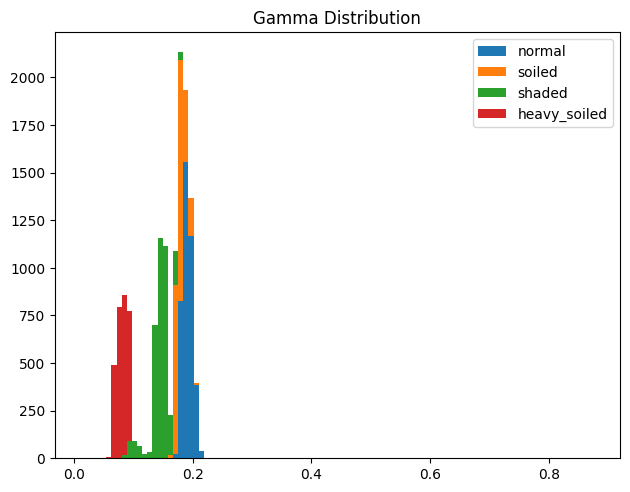

Gamma outcome looks similar to power


In [12]:
df_by_label = dataframe_splitter(df, "Gamma")

plt.hist(df_by_label, bins=100, stacked=True)
plt.legend(label_names)
plt.tight_layout()
plt.title("Gamma Distribution")
plt.show()
print("Gamma outcome looks similar to power")

In [13]:
# check for duplicates
data_types = ['Irradiance','Power','Gamma']
data_types_plus_label = data_types + ['Label']

dup_data_idx = df.duplicated(subset=data_types, keep=False)
n_dup_overall = dup_data_idx.sum()
print("Quantity of duplicates samples overall:")
print(n_dup_overall)

dup_data_label_idx = df.duplicated(subset=data_types_plus_label, keep=False)
n_dup_same_class = dup_data_label_idx.sum()
print("Quantity of duplicates from the same class:")
print(n_dup_same_class)

print("Quantity of duplicates from different classes:")
print(n_dup_overall - n_dup_same_class)

print("Similar samples is to be expected")
print("Identical samples will be impossible to differentiate by class")
print("Identical samples accross dataset split is bad")

Quantity of duplicates samples overall:
3373
Quantity of duplicates from the same class:
3291
Quantity of duplicates from different classes:
82
Similar samples is to be expected
Identical samples will be impossible to differentiate by class
Identical samples accross dataset split is bad


In [14]:
dup_data = df[dup_data_idx]
print("Quantity of duplicate samples:")
print(len(dup_data))

Quantity of duplicate samples:
3373


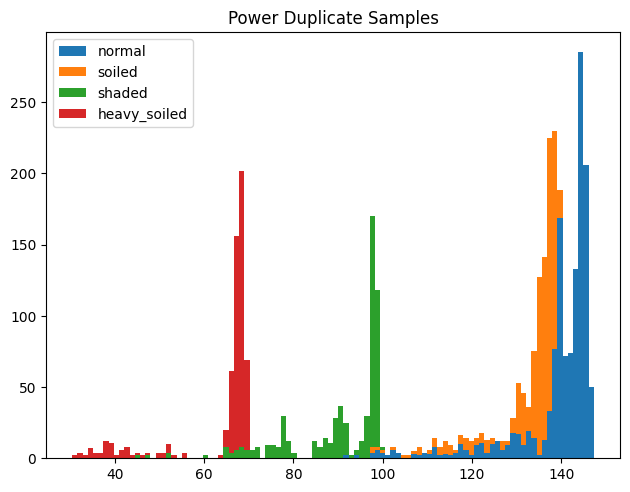

In [15]:
dup_data_by_label = dataframe_splitter(dup_data, "Power")

plt.hist(dup_data_by_label, bins=100, stacked=True)
plt.legend(label_names)
plt.tight_layout()
plt.title("Power Duplicate Samples")
plt.show()

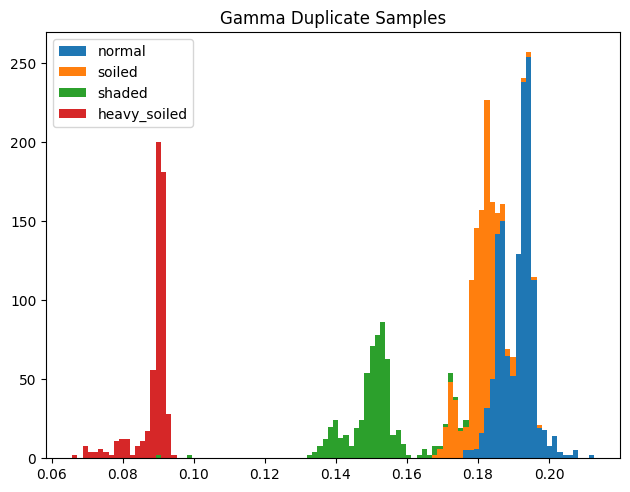

In [16]:
dup_data_by_label = dataframe_splitter(dup_data, "Gamma")

plt.hist(dup_data_by_label, bins=100, stacked=True)
plt.legend(label_names)
plt.tight_layout()
plt.title("Gamma Duplicate Samples")
plt.show()

# ML Experiment

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
data = df[data_types_plus_label].to_numpy()
y = data[:,3]
x = data[:,0:3]
print(x.shape)

idx = np.array(list(range(0,13285)))

(13285, 3)


In [19]:
x_train, x_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(x, y, idx, test_size=0.30, random_state=42, stratify=y)

x_val, x_test, y_val, y_test, idx_val, idx_test = train_test_split(x_temp, y_temp, idx_temp, test_size=0.50, random_state=42, stratify=y_temp)

print(x_train.shape)
print(y_train.shape)
print(idx_train.shape)

print(x_val.shape)
print(y_val.shape)
print(idx_val.shape)

print(x_test.shape)
print(y_test.shape)
print(idx_test.shape)

(9299, 3)
(9299,)
(9299,)
(1993, 3)
(1993,)
(1993,)
(1993, 3)
(1993,)
(1993,)


In [20]:
#idx_train.tofile('train_idx.csv', sep=',')
#idx_val.tofile('val_idx.csv', sep=',')
#idx_test.tofile('test_idx.csv', sep=',')

In [21]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, accuracy_score

xgb_model = xgb.XGBClassifier(objective="multi:softmax", random_state=42, eval_metric='merror')
xgb_model.fit(x_train, y_train, eval_set=[(x_val, y_val)])
y_pred = xgb_model.predict(x_test)

[0]	validation_0-merror:0.07878
[1]	validation_0-merror:0.05820
[2]	validation_0-merror:0.05469
[3]	validation_0-merror:0.05670
[4]	validation_0-merror:0.05770
[5]	validation_0-merror:0.05670
[6]	validation_0-merror:0.05670
[7]	validation_0-merror:0.05720
[8]	validation_0-merror:0.05670
[9]	validation_0-merror:0.05620
[10]	validation_0-merror:0.05670
[11]	validation_0-merror:0.05620
[12]	validation_0-merror:0.05620
[13]	validation_0-merror:0.05569
[14]	validation_0-merror:0.05519
[15]	validation_0-merror:0.05620
[16]	validation_0-merror:0.05519
[17]	validation_0-merror:0.05620
[18]	validation_0-merror:0.05620
[19]	validation_0-merror:0.05670
[20]	validation_0-merror:0.05670
[21]	validation_0-merror:0.05670
[22]	validation_0-merror:0.05670
[23]	validation_0-merror:0.05670
[24]	validation_0-merror:0.05720
[25]	validation_0-merror:0.05620
[26]	validation_0-merror:0.05770
[27]	validation_0-merror:0.05921
[28]	validation_0-merror:0.05770
[29]	validation_0-merror:0.05720
[30]	validation_0-me

In [32]:
y_pred = xgb_model.predict(x_test)

In [33]:
print(accuracy_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

0.9387857501254391
[[551  49   0   0]
 [ 70 343   0   0]
 [  0   1 555   1]
 [  0   0   1 422]]


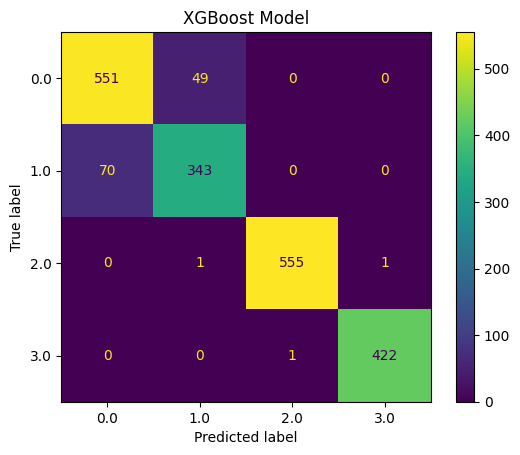

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("XGBoost Model")
plt.show()

In [24]:
1-(49+70+3)/1993

0.9387857501254391

In [25]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False).fit(y_train.reshape(-1, 1))

print(encoder.categories_)

y_train_1hot = encoder.transform(y_train.reshape(-1, 1))

y_test_1hot = encoder.transform(y_test.reshape(-1, 1))

print(y_train_1hot.shape)
print(y_test_1hot.shape)

[array([0., 1., 2., 3.])]
(9299, 4)
(1993, 4)


In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train)

x_train_scaled = scaler.transform(x_train)

x_test_scaled = scaler.transform(x_test)

In [ ]:
print("Why no validation? Duh!")

In [36]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(
    hidden_layer_sizes=(64, 32, 4), 
    activation='relu', 
    random_state=42, 
    solver='adam',
    learning_rate='adaptive',
    max_iter=1000,
    tol=0.00000001,
    verbose=True)

model.fit(x_train_scaled, y_train_1hot)

y_pred = model.predict(x_test_scaled)

Iteration 1, loss = 3.22238616
Iteration 2, loss = 3.03588723
Iteration 3, loss = 2.86512170
Iteration 4, loss = 2.71627194
Iteration 5, loss = 2.61366630
Iteration 6, loss = 2.40043268
Iteration 7, loss = 2.17972724
Iteration 8, loss = 2.03250889
Iteration 9, loss = 1.90126800
Iteration 10, loss = 1.65473622
Iteration 11, loss = 1.46913513
Iteration 12, loss = 1.40577662
Iteration 13, loss = 1.36505895
Iteration 14, loss = 1.33525389
Iteration 15, loss = 1.30298807
Iteration 16, loss = 1.27532236
Iteration 17, loss = 1.24880468
Iteration 18, loss = 1.22441536
Iteration 19, loss = 1.20200801
Iteration 20, loss = 1.17581637
Iteration 21, loss = 1.15306541
Iteration 22, loss = 1.13204054
Iteration 23, loss = 1.11043687
Iteration 24, loss = 1.08993846
Iteration 25, loss = 1.06979542
Iteration 26, loss = 1.04996036
Iteration 27, loss = 1.03254945
Iteration 28, loss = 1.01475707
Iteration 29, loss = 0.99694160
Iteration 30, loss = 0.97892717
Iteration 31, loss = 0.96378137
Iteration 32, los

In [ ]:
y_pred = model.predict(x_test_scaled)

In [37]:
print("Where is the accuracy?")

print(confusion_matrix(y_test_1hot.argmax(axis=1), y_pred.argmax(axis=1)))

[[575  25   0   0]
 [124 288   1   0]
 [  0   2 554   1]
 [  0   0   0 423]]


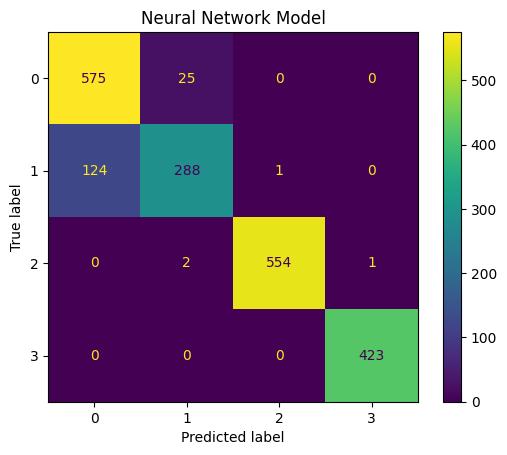

In [39]:
ConfusionMatrixDisplay.from_predictions(y_test_1hot.argmax(axis=1), y_pred.argmax(axis=1))
plt.title("Neural Network Model")
plt.show()

In [ ]:
1-(124+25+4)/1993

0.9232313095835424

In [ ]:
# In the Test Set, how many conflicting duplicates are there?
# How many things are we garenteed to get wrong?

In [ ]:
# ANN with TensorFlow
